### Para não ter problemas de import, estou copiando a função normalize da toolbox

In [35]:
import numpy as np

def normalize(f, range=[0,255]):

    f = np.asarray(f)
    range = np.asarray(range)
    if f.dtype.char in ['D', 'F']:
        raise Exception('error: cannot normalize complex data')
    faux = np.ravel(f).astype(float)
    minimum = faux.min()
    maximum = faux.max()
    lower = range[0]
    upper = range[1]
    if upper == lower:
        g = np.ones(f.shape) * maximum
    if minimum == maximum:
        g = np.ones(f.shape) * (upper + lower) / 2.
    else:
        g = (faux-minimum)*(upper-lower) / (maximum-minimum) + lower
    g = g.reshape(f.shape)

    if f.dtype == np.uint8:
        if upper > 255: 
            raise Exception('normalize: warning, upper valuer larger than 255. Cannot fit in uint8 image')
    if lower == 0 and upper == 255:
        g = g.astype(np.uint8)
    else:
        g = g.astype(f.dtype) # set data type of result the same as the input image
    return g

# Ex03 - Histograma e Transformações de intensidade

Esta atividade tem 2 objetivos principais: 
    - entender o conceito de histograma e estatísticas da imagem
    - explorar várias formas de transformação de intensidade dos pixels. 

## Parte 1 - Histograma

Leia o notebook [Histograma de imagens]('05 Histograma da imagem.ipynb') para entender o conceito de histograma. Além da contagem dos pixels, outras estatísticas podem ser interessantes. Veja abaixo a função h2stats. Ela calcula várias estatísticas da imagem a partir do histograma. Porém, ela foi originalmente desenvolvida para funcionar com a função ia.histogram (antiga toolbox da disciplina).

In [2]:
def h2stats(h):
    import numpy as np
    #import ia898.src as ia

    hn = 1.0*h/h.sum() # compute the normalized image histogram
    v = np.zeros(6) # number of statistics

    # compute statistics
    n = len(h) # number of gray values
    v[0]  = np.sum((np.arange(n)*hn)) # mean
    v[1]  = np.sum(np.power((np.arange(n)-v[0]),2)*hn) # variance
    v[2]  = np.sum(np.power((np.arange(n)-v[0]),3)*hn)/(np.power(v[1],1.5))# skewness
    v[3]  = np.sum(np.power((np.arange(n)-v[0]),4)*hn)/(np.power(v[1],2))-3# kurtosis
    v[4]  = -(hn[hn>0]*np.log(hn[hn>0])).sum() # entropy
    v[5]  = np.argmax(h) # mode
    return v

Vamos agora fazer um teste, calculando o histograma usando a função np.histogram e depois calculando as estatísticas da imagem:

In [3]:
import numpy as np
f = np.array([1,1,1,0,1,2,2,2,1])
h, bins = np.histogram(f)
print('statistics =', h2stats(h))

statistics = [ 5.77777778  7.50617284 -0.51254498 -0.16094616  0.93688831  5.        ]


Os valores calculados parecem corretos? Vejamos o valor da média, por exemplo, usando a função np.mean:

In [4]:
print(np.mean(f))

1.2222222222222223


Porque os valores de média calculados pela h2stats (5.7777778) e pela np.mean(1.2222222222) são diferentes? Muito provavelmente o problema é a diferença entre a função ia.histogram e np.histogram. 

### Exercício 1
Pensando que gostaríamos de usar a função h2stats com a função np.histogram, descubram se há uma forma correta de usar a função np.histogram para obter os valores corretos das estatísticas sem alterar a função h2stats. Caso vocês não obtenham sucesso, alterem a função h2stats para que os cálculos fiquem corretos. Testem com arrays numéricos pequenos. Para checar se as estatísticas retornadas estão corretas, usem funções do Numpy e, eventualmente, do Scipy para confirmar (por exemplo: np.mean( ), scipy.stats.skew( )).


O problema é que o np.histogram gera uma quantidade de bins que são faixas, de acordo com a quantidade de valores, enquanto o ia.histogram gera a quantidade de bins unitários sendo uma contagem de 0 ao valor máximo do array.

* Obs: O h2stats tira a média somando um np.arange do tamanho do histograma, que é unitário e dividindo pela soma dos valores do histograma (que é apenas uma contagem total dos itens do vetor/imagem). Ou seja, um histograma de tamanho 15: (0 + 1 + 2 .. + 14) * (0/15 + 1/15 + 2/15 + ... 14/15)

In [5]:
import numpy as np
import sys
import os
ia898path = os.path.abspath('../')
if ia898path not in sys.path:
    sys.path.append(ia898path)
import src as ia
import scipy.stats as sc

f = np.array([1,1,1,0,1,2,2,2,1])

g = np.random.randint(32, size=16)

h1, bins1 = np.histogram(g, bins=g.max() + 1, range=(0, g.max()))
h2 = ia.histogram(g)

print(g)

print('valor de h1: {}'.format(h1))
print('valor de h2: {}\n'.format(h2))
print('statistics =', h2stats(h1))

stats = np.array([np.mean(g), np.var(g), sc.skew(g), sc.kurtosis(g), sc.entropy(h1)])
print("statistics2 = {}".format(stats, end='\n\n'))

h, bins = np.histogram(f, bins=len(np.unique(f)))
print(np.unique(f))
print(h)
print(bins)
print('statistics =', h2stats(h))
stats = np.array([np.mean(f), np.var(f), sc.skew(f), sc.kurtosis(f), sc.entropy(h)])
print("statistics2 = {}".format(stats, end='\n\n'))

[ 6  9 18  2 15 27  4 10 17 18  3 14 19 21 19  1]
valor de h1: [0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 2 2 0 1 0 0 0 0 0 1]
valor de h2: [0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 2 2 0 1 0 0 0 0 0 1]

statistics = [ 1.26875000e+01  5.75898438e+01 -4.95758295e-02 -1.10932295e+00
  2.59930193e+00  1.80000000e+01]
statistics2 = [ 1.26875000e+01  5.75898438e+01 -4.95758295e-02 -1.10932295e+00
  2.59930193e+00]
[0 1 2]
[1 5 3]
[0.         0.66666667 1.33333333 2.        ]
statistics = [ 1.22222222  0.39506173 -0.20992233 -0.62109375  0.93688831  1.        ]
statistics2 = [ 1.22222222  0.39506173 -0.20992233 -0.62109375  0.93688831]


## Parte 2 - Transformação de Intensidade

É a categoria de funções que apenas alteram o valor do pixel aplicando-se uma função ou tabela de mapeamento. Estudem atentamente os tutoriais sobre Transformada de intensidade e sobre Equalização de histograma. O último tutorial mostra que é possível fazer a equalização da imagem utilizando também o conceito usado para construir um mosaico com tons de cinza igualmente distribuídos. 

### Exercício 2 
Exercite transformações de intensidade em uma imagem.

### Exercício 3
Veja a imagem abaixo. Escolha um valor de limiar (threshold) para separar as bolachas do fundo da imagem. Dica: Visualize o histograma da imagem para escolher o valor. Crie primeiro uma função de transformação T e depois aplique esta transformação para obter o objeto de interesse (cookies) pintados de branco e o fundo em preto.

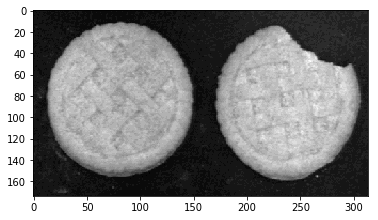

In [6]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
f = mpimg.imread('../figures/cookies.pgm')  
plt.imshow(f,cmap='gray')

No caso abaixo, eu criei um array T binário, em que os indices das posições maiores que 100 são true, enquanto os menores ou iguais, false. Fiz isso baseado no histograma da própria imagem (abaixo):

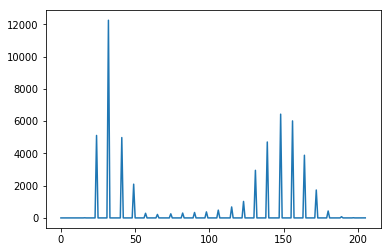

In [7]:
T = ia.normalize((np.arange(256) > 100))
h_cookie, bins_cookie = np.histogram(f, bins=f.max() + 1, range=(0, f.max()))
plt.plot(h_cookie)
plt.show()

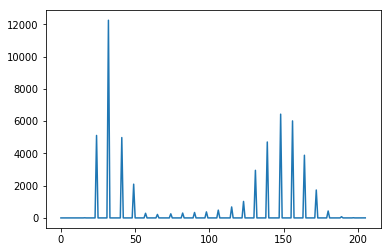

(174, 314)


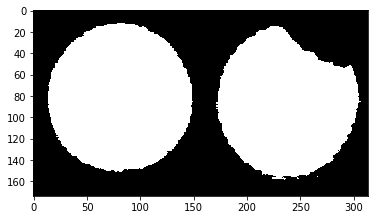

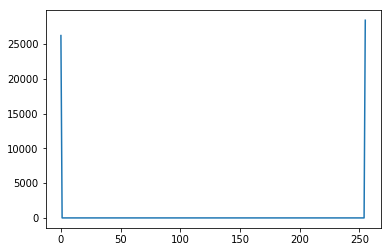

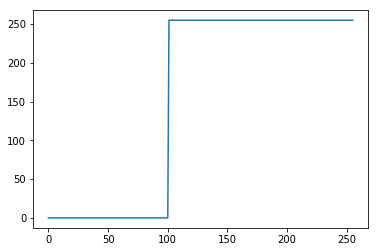

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 25

In [8]:
T = ia.normalize((np.arange(256) > 100))
h_cookie, bins_cookie = np.histogram(f, bins=f.max() + 1, range=(0, f.max()))
plt.plot(h_cookie)
plt.show()
print(f.shape)

plt.imshow(T[f], cmap='gray')
plt.show()

h_cookie, bins_cookie = np.histogram(T[f], bins=T[f].max() + 1, range=(0, T[f].max()))
plt.plot(h_cookie)
plt.show()

plt.plot(T)
plt.show()

print(T)

### Exercício 4
Você é capaz de transformar a imagem para identificar o número da placa do carro apresentado na imagem abaixo? 

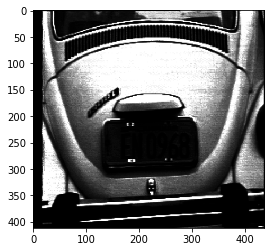

In [71]:
f = mpimg.imread('../figures/fusca.png')
plt.imshow(f,cmap='gray')

In [10]:
print(f.shape)
print("Min: {} \t Max: {}".format(f.min(), f.max()))

(412, 438)
Min: 0.0 	 Max: 0.6745098233222961


""
Equalizacao
""
Funçao logaritmica

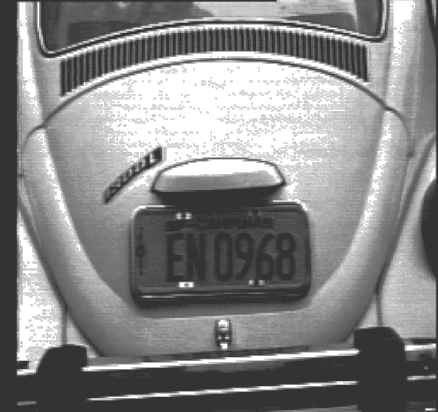
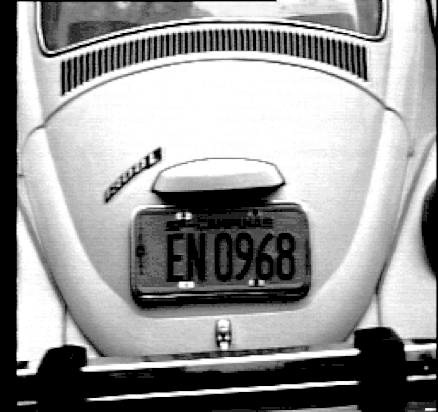

In [38]:
n = f.size
h = ia.histogram(normalize(f))
nb = ia.nbshow()
#plt.plot(h)

T = 255./n * np.cumsum(h)
nb.nbshow(T[normalize(f)].astype('uint8'), 'Equalizacao')

T2 = normalize(np.log(np.arange(256).astype('uint8') + 1.))

#nb = ia.nbshow()
nb.nbshow(T2[normalize(f)].astype('uint8'),'Funçao logaritmica')
nb.nbshow()

### Exercício 5
Escreva uma função que implemente a tranformação de brilho e contraste de uma imagem em níveis de cinza, baseada na construçao de três segmentos de retas:

- Primeiro segmento de reta: 'x' de '0' a 'x1', com angulo 'alpha';
- Segundo segmento de reta: 'x' de 'x1' a 'x2', com angulo 'beta';
- Terceiro segmento de reta: 'x' de 'x2' a '255';
- Retorno: mapeamento de brilho & contraste da 'imagem' de entrada.


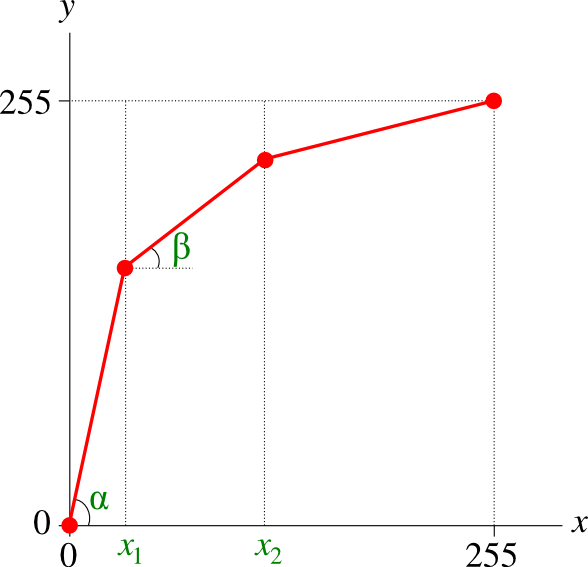

In [12]:
from PIL import Image
ang = Image.open('../figures/bc_angulos.png')
ang

Dicas:

- Determine *y1* e *y2* a partir de *alpha* e *beta*.
- Utilize a equação da reta, tendo dois pontos conhecidos *(xa,ya)* e *(xb,yb)*, para cada trecho de reta


#### Exercício 5:
Assumindo a equação da reta:

$y = ax + b$

Para determinar o coeficiente linear $b$ de cada segmento:

$-b = ax - y$

Também assumindo o coeficiente angular $a$:

$a=\Delta{x}/\Delta{y}$

Ou, com ângulo $\theta$ conhecido:

$a=tan(\theta)$

Para o problema apresentado:

$a_n=\frac{y_n-y_{n-1}}{x_n-x_{n-1}}=tan(\theta_n)$

Portanto:

$-b_n=a_nx_n-y_n$


In [39]:
def transform(x1y1=(20, 100), x2y2=(100,200), x3y3=(255,255), res=256):
    # Assumindo valores padrão, caso não sejam informados
    T = np.arange(res).astype('uint8')
    x1, y1 = x1y1
    x2, y2 = x2y2
    x3, y3 = x3y3
    
    a1 = (y1/x1)
    a2 = (y2-y1)/(x2-x1)
    a3 = (y3-y2)/(x3-x2)

    b1 = 0
    b2 = -((a2*x2)-y2)
    b3 = -((a3*x3)-y3)

    T1 = a1*T[:x1:]
    T2 = a2*T[x1:x2:] + b2
    T3 = a3*T[x2::] + b3
    Tfinal=np.concatenate((T1,T2,T3))
    return Tfinal


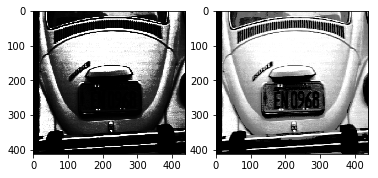

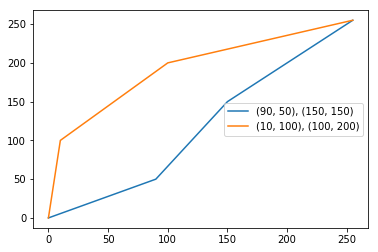

In [68]:
from math import pi
Tfinal1 = transform((90,50),(150,150))
Tfinal2 = transform((10,100),(100,200),(255,255),256)

normalized_f = normalize(f, [0,255])
ffinal1=Tfinal1[normalized_f]

plt.subplot(121)
plt.imshow(ffinal1,cmap='gray')

plt.subplot(122)
ffinal2=Tfinal2[normalized_f]
plt.imshow(ffinal2,cmap='gray')

plt.show()

plt.plot(Tfinal1)
plt.plot(Tfinal2)
plt.legend(['{}, {}'.format((90,50),(150,150)), '{}, {}'.format((10,100),(100,200))], loc='right')
plt.show()
